In [533]:
# Imports and boilerplate to make graphs look better
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

def setup_graph(title='', x_label='', y_label='', fig_size=None):
    fig = plt.figure()
    if fig_size != None:
        fig.set_size_inches(fig_size[0], fig_size[1])
    ax = fig.add_subplot(111)
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)

# Random Forest and XGBoost

I want to understand roughly how random forest decision trees perform, and compare that with xgboost. I'll use `y=x^2` as a sample problem to learn against.

## Training/testing set

First, let's define our training and data sets...

In [534]:
# Training x and training y
x_train = np.random.uniform(-5, 5, 1000)
y_train = x_train**2 + np.random.normal(0, 1, 1000)

# To draw the true `y=x^2`...
x_true = np.linspace(-5, 5, 1000)
y_true = x_true**2

# Test data - note that we go outside the bounds of the testing data
x_test = np.linspace(-10, 10, 100)

### Visualize testing data

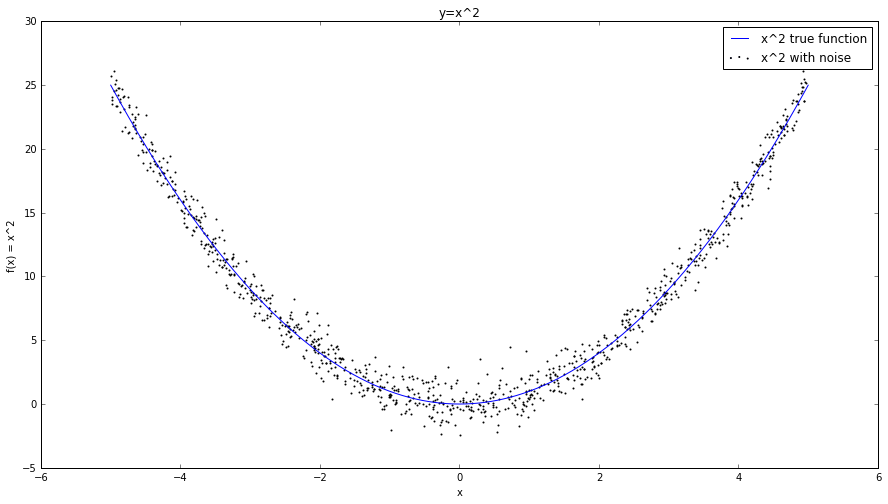

In [535]:
setup_graph(title='y=x^2', x_label='x', y_label='f(x) = x^2', fig_size=(15,8))
plt.scatter(x_train, y_train, s=1, label="x^2 with noise")
plt.plot(x_true, y_true, c="b", label="x^2 true function")
plt.legend(loc="best")
plt.show()

In [536]:
import xgboost as xgb

### Train

In [537]:
param = {'max_depth': 3, 'eta': 1, 'silent': 1, 'objective': 'reg:linear', 'num_feature': 1, 'base_score': 0}
num_round = 4
train_dmatrix = xgb.DMatrix(data=x_train.reshape(-1,1), label=y_train.reshape(-1,1))
bst = xgb.train(param, train_dmatrix, num_round)

### Predict

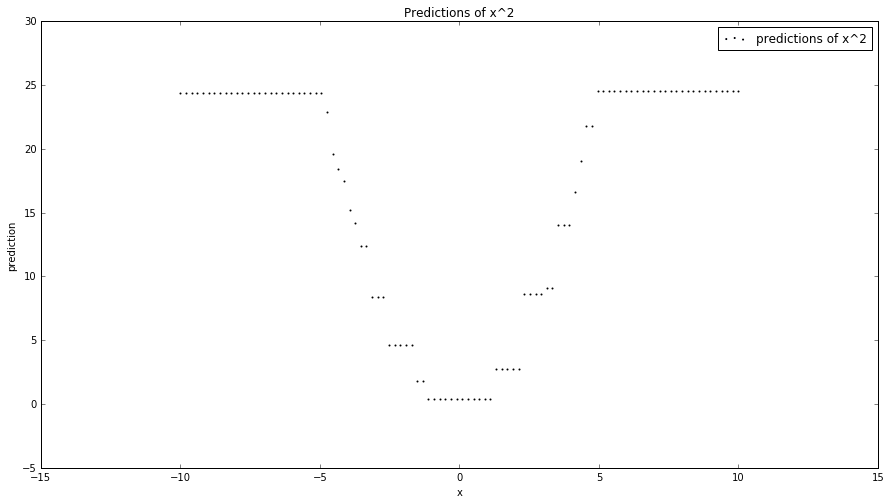

In [538]:
x_predict = np.linspace(-10, 10, 100)
xgb_predictions_x2 = bst.predict(xgb.DMatrix(x_predict.reshape(-1, 1)))

setup_graph(title='Predictions of x^2', x_label='x', y_label='prediction', fig_size=(15,8))
plt.scatter(x_predict, xgb_predictions_x2, s=1, label="predictions of x^2")
plt.legend(loc="best")
plt.show()

# Predict without xgboost library

### Save model to file

In [539]:
bst.dump_model('dump.raw.txt')

In [540]:
with open('dump.raw.txt') as f:
    data = f.read()
    print(data)

booster[0]:
0:[f0<3.52787] yes=1,no=2,missing=1
	1:[f0<-3.23679] yes=3,no=4,missing=3
		3:[f0<-4.05982] yes=7,no=8,missing=7
			7:leaf=20.4628
			8:leaf=12.9802
		4:[f0<2.32098] yes=9,no=10,missing=9
			9:leaf=2.7657
			10:leaf=8.61868
	2:[f0<4.20769] yes=5,no=6,missing=5
		5:leaf=14.8508
		6:leaf=21.0533
booster[1]:
0:[f0<-1.66148] yes=1,no=2,missing=1
	1:[f0<-3.23679] yes=3,no=4,missing=3
		3:[f0<-4.60265] yes=7,no=8,missing=7
			7:leaf=2.75122
			8:leaf=-0.551092
		4:[f0<-2.6173] yes=9,no=10,missing=9
			9:leaf=5.68575
			10:leaf=1.92935
	2:[f0<1.22308] yes=5,no=6,missing=5
		5:[f0<-1.13687] yes=11,no=12,missing=11
			11:leaf=-0.882887
			12:leaf=-2.29562
		6:[f0<4.83122] yes=13,no=14,missing=13
			13:leaf=0.0444313
			14:leaf=3.29329
booster[2]:
0:[f0<-4.05982] yes=1,no=2,missing=1
	1:[f0<-4.36698] yes=3,no=4,missing=3
		3:[f0<-4.83739] yes=7,no=8,missing=7
			7:leaf=1.09046
			8:leaf=-0.395867
		4:[f0<-4.192] yes=9,no=10,missing=9
			9:leaf=-1.54699
			10:leaf=-2.50296
	2:[f0<-3.6

# Parse model dump

So now let's write a function to parse the model text.

In [541]:
with open('dump.raw.txt') as f:
    raw_model_text = [line.strip() for line in f.readlines()]

In [542]:
def get_indention_level(line):
    indention_level = 0
    for c in line:
        if c != '\t':
            return indention_level
        else:
            indention_level += 1

    # If we never saw a non-tab character, assume it's a blank line
    return 0

In [543]:
get_indention_level('Hello')

0

In [544]:
get_indention_level('\t\tHello')

2

In [545]:
def parse_condition(condition_text):
    for oper in ['<', '=', '>']:
        oper_index = condition_text.find(oper)
        if oper_index > 0:
            feature = condition_text[0:oper_index]
            operator = condition_text[oper_index]
            comparison_val_raw = condition_text[oper_index+1:]
            try:
                comparison_val = float(comparison_val_raw)
            except ValueError:
                # Assume it's supposed to be a string value, like for classification
                comparison_val = comparison_val_raw
            return (feature, operator, comparison_val)
    return (None, None, None)

In [546]:
parse_condition('f1<10.2916')

('f1', '<', 10.2916)

In [547]:
def parse_result(result_text):
    raw_dict = dict([part.split('=') for part in result_text.split(',')])
    key_map = {'yes': True, 'no': False, 'missing': None}
    return {key_map[k]:int(v) for k,v in raw_dict.items()}

In [548]:
parse_result('yes=1,no=2,missing=1')

{False: 2, True: 1, None: 1}

In [549]:
def parse_branch_line(line):
    if line.startswith('leaf'):
        leaf = line.split('=')[1]
        try:
            return float(leaf)
        except ValueError:
            # Assume it's supposed to be a string value, like for classification
            return leaf
    elif line.startswith('['):
        condition_close = line.find(']')
        condition_text = line[1:condition_close]
        result_text = line[condition_close+2:]
        return {'condition': parse_condition(condition_text), 'result': parse_result(result_text)}

In [550]:
parse_branch_line('[f1<10.2916] yes=1,no=2,missing=1')

{'condition': ('f1', '<', 10.2916), 'result': {False: 2, True: 1, None: 1}}

In [551]:
def parse_xgboost_model(lines):
    trees = []
    tree_num = 0
    tree = {}

    for line in lines:
        if line.startswith('booster'):
            tree = {}
            trees.append(tree)
        else:
            indent_level = get_indention_level(line)
            comma_location = line.find(':')
            branch_num = int(line[indent_level:comma_location])
            branch_text = line[comma_location+1:]
            tree[branch_num] = parse_branch_line(branch_text)
    return trees

In [552]:
parse_xgboost_model(raw_model_text)

[{0: {'condition': ('f0', '<', 3.52787),
   'result': {False: 2, True: 1, None: 1}},
  1: {'condition': ('f0', '<', -3.23679),
   'result': {False: 4, True: 3, None: 3}},
  2: {'condition': ('f0', '<', 4.20769),
   'result': {False: 6, True: 5, None: 5}},
  3: {'condition': ('f0', '<', -4.05982),
   'result': {False: 8, True: 7, None: 7}},
  4: {'condition': ('f0', '<', 2.32098),
   'result': {False: 10, True: 9, None: 9}},
  5: 14.8508,
  6: 21.0533,
  7: 20.4628,
  8: 12.9802,
  9: 2.7657,
  10: 8.61868},
 {0: {'condition': ('f0', '<', -1.66148),
   'result': {False: 2, True: 1, None: 1}},
  1: {'condition': ('f0', '<', -3.23679),
   'result': {False: 4, True: 3, None: 3}},
  2: {'condition': ('f0', '<', 1.22308),
   'result': {False: 6, True: 5, None: 5}},
  3: {'condition': ('f0', '<', -4.60265),
   'result': {False: 8, True: 7, None: 7}},
  4: {'condition': ('f0', '<', -2.6173),
   'result': {False: 10, True: 9, None: 9}},
  5: {'condition': ('f0', '<', -1.13687),
   'result': {Fa

## Transform parsed tree into processing-ready tree

In [553]:
import operator

operator_map = {'<': operator.lt, '=': operator.eq, '>': operator.gt}

def make_branch_processor(branch):
    feature_name, operator_name, condition_val = branch['condition']
    result_map = branch['result']
    operator = operator_map[operator_name]
    def run_branch(sample):
        sample_val = sample.get(feature_name, None)
        if sample_val:
            bool_result = operator(sample_val, condition_val)
            return result_map[bool_result]
        else:
            return result_map[sample_val]
    return run_branch

def make_prediction_tree(parsed_tree):
    prediction_tree = {}
    for branch_num, branch in parsed_tree.items():
        if type(branch) == dict:
            prediction_tree[branch_num] = make_branch_processor(branch)
        else:
            prediction_tree[branch_num] = branch
    return prediction_tree

def make_prediction_forest(parsed_forest):
    return [make_prediction_tree(tree) for tree in parsed_forest]

In [554]:
gradient_boosted_forest = make_prediction_forest(parse_xgboost_model(raw_model_text))
gradient_boosted_forest

[{0: <function __main__.make_branch_processor.<locals>.run_branch>,
  1: <function __main__.make_branch_processor.<locals>.run_branch>,
  2: <function __main__.make_branch_processor.<locals>.run_branch>,
  3: <function __main__.make_branch_processor.<locals>.run_branch>,
  4: <function __main__.make_branch_processor.<locals>.run_branch>,
  5: 14.8508,
  6: 21.0533,
  7: 20.4628,
  8: 12.9802,
  9: 2.7657,
  10: 8.61868},
 {0: <function __main__.make_branch_processor.<locals>.run_branch>,
  1: <function __main__.make_branch_processor.<locals>.run_branch>,
  2: <function __main__.make_branch_processor.<locals>.run_branch>,
  3: <function __main__.make_branch_processor.<locals>.run_branch>,
  4: <function __main__.make_branch_processor.<locals>.run_branch>,
  5: <function __main__.make_branch_processor.<locals>.run_branch>,
  6: <function __main__.make_branch_processor.<locals>.run_branch>,
  7: 2.75122,
  8: -0.551092,
  9: 5.68575,
  10: 1.92935,
  11: -0.882887,
  12: -2.29562,
  13: 0

## Now lets figure out how to make predictions with our lovely new forest

Let's see how to traverse the tree manually first.

We just repeatedly call the branch (if it's callable), and pass in the sample.

In [555]:
gradient_boosted_forest[0][0]({'f0': 4})

2

### Now let's code it

In [556]:
def eval_tree(tree, sample):
    branch_num = 0
    while True:
        branch = tree[branch_num]
        if not callable(tree[branch_num]):
            break  # Leaf
        else:
            branch_num = tree[branch_num](sample)
    return tree[branch_num]

In [557]:
eval_tree(gradient_boosted_forest[0], {'f0': 4})

14.8508

### Now let's write the eval forest logic

In [558]:
def eval_forest(forest, sample, aggregation_func=None):
    if not aggregation_func:
        aggregation_func = sum
    leaves = [eval_tree(tree, sample) for tree in forest]
    #print('Leaves: {}'.format(leaves))
    return aggregation_func(leaves)

In [559]:
eval_forest(gradient_boosted_forest, {'f0': 4})

16.5856113

Let's make sure it's the same as xgboost

In [560]:
param = {'max_depth': 3, 'eta': 1, 'silent': 1, 'objective': 'reg:linear', 'num_feature': 1}
num_round = 4
train_dmatrix = xgb.DMatrix(data=x_train.reshape(-1,1), label=y_train.reshape(-1,1))
bst = xgb.train(param, train_dmatrix, num_round)
bst.predict(xgb.DMatrix([[4]]))

array([ 16.58567619], dtype=float32)

**And yes, they're the same!**

### Graph of our prediction logic's predictions

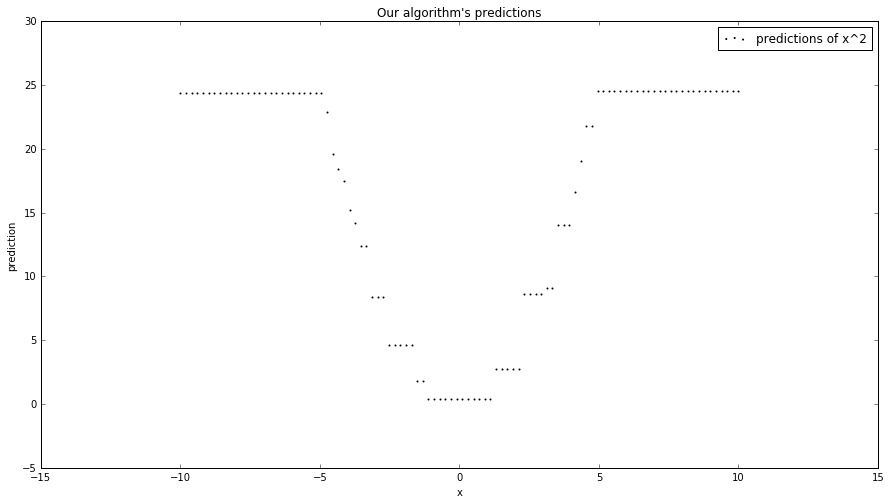

In [566]:
x_predict = np.linspace(-10, 10, 100)
y_predict = [eval_forest(gradient_boosted_forest, {'f0': sample}) for sample in x_predict]

setup_graph(title='Our algorithm\'s predictions', x_label='x', y_label='prediction', fig_size=(15,8))
plt.scatter(x_predict, y_predict, s=1, label="predictions of x^2")
plt.legend(loc="best")
plt.show()

### Let's compare next to the xgboost predictions

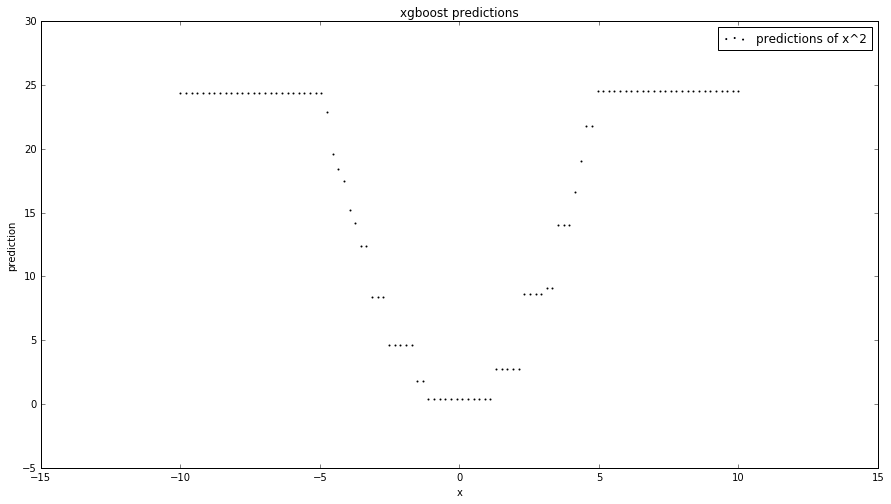

In [567]:
setup_graph(title='xgboost predictions', x_label='x', y_label='prediction', fig_size=(15,8))
plt.scatter(x_predict, xgb_predictions_x2, s=1, label="predictions of x^2")
plt.legend(loc="best")
plt.show()

In [563]:
bst.predict(xgb.DMatrix([[-5], [-3], [1], [3], [10]]))

array([ 24.40184402,   8.40028572,   0.41890651,   9.09495926,  24.53758049], dtype=float32)

In [564]:
[eval_forest(gradient_boosted_forest, {'f0': sample}) for sample in [-5, -3, 1, 3, 10]]

[24.4017325, 8.3996935, 0.41832349999999985, 9.096313799999999, 24.537601]

# Full code

## parse model text

In [568]:
def get_indention_level(line):
    indention_level = 0
    for c in line:
        if c != '\t':
            return indention_level
        else:
            indention_level += 1

    # If we never saw a non-tab character, assume it's a blank line
    return 0

def parse_condition(condition_text):
    for oper in ['<', '=', '>']:
        oper_index = condition_text.find(oper)
        if oper_index > 0:
            feature = condition_text[0:oper_index]
            operator = condition_text[oper_index]
            comparison_val_raw = condition_text[oper_index+1:]
            try:
                comparison_val = float(comparison_val_raw)
            except ValueError:
                # Assume it's supposed to be a string value, like for classification
                comparison_val = comparison_val_raw
            return (feature, operator, comparison_val)
    return (None, None, None)

def parse_result(result_text):
    raw_dict = dict([part.split('=') for part in result_text.split(',')])
    key_map = {'yes': True, 'no': False, 'missing': None}
    return {key_map[k]:int(v) for k,v in raw_dict.items()}

def parse_branch_line(line):
    if line.startswith('leaf'):
        leaf = line.split('=')[1]
        try:
            return float(leaf)
        except ValueError:
            # Assume it's supposed to be a string value, like for classification
            return leaf
    elif line.startswith('['):
        condition_close = line.find(']')
        condition_text = line[1:condition_close]
        result_text = line[condition_close+2:]
        return {'condition': parse_condition(condition_text), 'result': parse_result(result_text)}

def parse_xgboost_model(lines):
    trees = []
    tree_num = 0
    tree = {}

    for line in lines:
        if line.startswith('booster'):
            tree = {}
            trees.append(tree)
        else:
            indent_level = get_indention_level(line)
            comma_location = line.find(':')
            branch_num = int(line[indent_level:comma_location])
            branch_text = line[comma_location+1:]
            tree[branch_num] = parse_branch_line(branch_text)
    return trees

def load_xgboost_model(model_path):
    with open(model_path) as f:
        raw_model_text = [line.strip() for line in f.readlines()]
    return parse_xgboost_model(raw_model_text)

## Prediction logic

In [569]:
import operator

operator_map = {'<': operator.lt, '=': operator.eq, '>': operator.gt}

def make_branch_processor(branch):
    feature_name, operator_name, condition_val = branch['condition']
    result_map = branch['result']
    operator = operator_map[operator_name]
    def run_branch(sample):
        sample_val = sample.get(feature_name, None)
        if sample_val:
            bool_result = operator(sample_val, condition_val)
            return result_map[bool_result]
        else:
            return result_map[sample_val]
    return run_branch

def make_prediction_tree(parsed_tree):
    prediction_tree = {}
    for branch_num, branch in parsed_tree.items():
        if type(branch) == dict:
            prediction_tree[branch_num] = make_branch_processor(branch)
        else:
            prediction_tree[branch_num] = branch
    return prediction_tree

def make_prediction_forest(parsed_forest):
    return [make_prediction_tree(tree) for tree in parsed_forest]

def eval_tree(tree, sample):
    branch_num = 0
    while True:
        branch = tree[branch_num]
        if not callable(tree[branch_num]):
            break  # Leaf
        else:
            branch_num = tree[branch_num](sample)
    return tree[branch_num]

def eval_forest(forest, sample, aggregation_func=None):
    if not aggregation_func:
        aggregation_func = sum
    leaves = [eval_tree(tree, sample) for tree in forest]
    return aggregation_func(leaves)

## Usage

In [571]:
gradient_boosted_forest = make_prediction_forest(load_xgboost_model('dump.raw.txt'))
eval_forest(gradient_boosted_forest, {'f0': 4})

16.5856113